In [21]:
import getpass
import os

os.environ["MISTRAL_API_KEY"] = "cL9j05Qnp17FgSxqAlO4N7V17AXdtSVt"
api_key = os.getenv('MISTRAL_API_KEY')

os.environ["TAVILY_API_KEY"] = "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"
tavily_api_key = os.getenv('TAVILY_API_KEY')

In [29]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [30]:
from langchain_mistralai import ChatMistralAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

model = ChatMistralAI(model="mistral-large-latest")

tool = TavilySearchResults(max_results=2)
tools = [tool]
## Modification: tell the LLM which tools it can call
model_with_tools = model.bind_tools(tools)

In [31]:
def chatbot(state: State):
    return {"messages": [model_with_tools.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [32]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [33]:

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

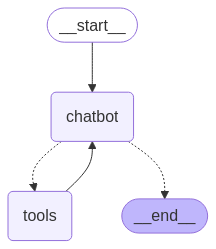

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        output = graph.ainvoke({"messages": user_input})
        print(output["messages"][-1].pretty_print())
        #stream_graph_updates(user_input)
        break

User:  What's your name?


Assistant: I don't have a name. I'm an AI assistant here to help you with information and tasks. How can I assist you today?


User:  My Name is Joy


Assistant: Nice to meet you, Joy! How can I assist you today?


User:  What's my name?


Assistant: You told me your name is Joy! Is there something you would like help with today?


User:  Great!


Assistant: I'm glad to hear that! How can I assist you further, Joy? If you have any questions or need help with something specific, feel free to let me know!


User:  What's the weather in Delhi, only details like temprature only?


Assistant: 
Assistant: [{"title": "Weather in Delhi, India", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Delhi', 'region': 'Delhi', 'country': 'India', 'lat': 28.6667, 'lon': 77.2167, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1743062989, 'localtime': '2025-03-27 13:39'}, 'current': {'last_updated_epoch': 1743062400, 'last_updated': '2025-03-27 13:30', 'temp_c': 35.2, 'temp_f': 95.4, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 10.3, 'wind_kph': 16.6, 'wind_degree': 274, 'wind_dir': 'W', 'pressure_mb': 1008.0, 'pressure_in': 29.77, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 22, 'cloud': 25, 'feelslike_c': 33.4, 'feelslike_f': 92.2, 'windchill_c': 37.4, 'windchill_f': 99.2, 'heatindex_c': 36.2, 'heatindex_f': 97.1, 'dewpoint_c': 0.1, 'dewpoint_f': 32.3, 'vis_km': 6.0, 'vis_miles': 3.0, 'uv': 8.2, 'gust_mph': 11.8, 'gust_kph': 19.0}}", "score": 0.9952145}, {"titl